In [1]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 15.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
from data.dataset import generate_time_series, generate_and_save_time_series, MultiTimeSeriesDataset, TSPreprocessor
from models.model import DecoderOnlyTransformer
import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
model = DecoderOnlyTransformer(
        num_layers=4,
        model_dim=128,
        num_heads=8,
        hidden_dim=512,
        quantized_classes=103,
        padding_idx=102
    )
state_dict = torch.load("/home/pratikdoshi/projects/time-series/tsfm-archived/TSFM-ArchFix/tsfm_10432.pt", weights_only=True)
model.load_state_dict(state_dict)
#model.eval()

<All keys matched successfully>

## Synthetic Data Performance

In [4]:
# generate test samples
generate_and_save_time_series(1024, 1024, "test_dir", series_length_range=(128, 256))

Saved 1024 samples to test_dir/preprocessed_data_1.pt


In [5]:
test_tensors, metadata, preprocessor = TSPreprocessor.from_preprocessed_file("test_dir/preprocessed_data_1.pt")
print('Lengths:',len(test_tensors), len(metadata))
ten_lens = [len(t) for t in test_tensors]
print('Min Seq Length:',min(ten_lens))
print('Min Seq Length:',max(ten_lens))

Lengths: 1024 1024
Min Seq Length: 128
Min Seq Length: 256


In [6]:
test = test_tensors[0].long()

In [7]:
test.shape

torch.Size([245])

In [9]:
from utils.core import get_causal_mask
causal_mask = get_causal_mask(len(test))
with torch.no_grad():
    logits = model(test.unsqueeze(0),causal_mask)

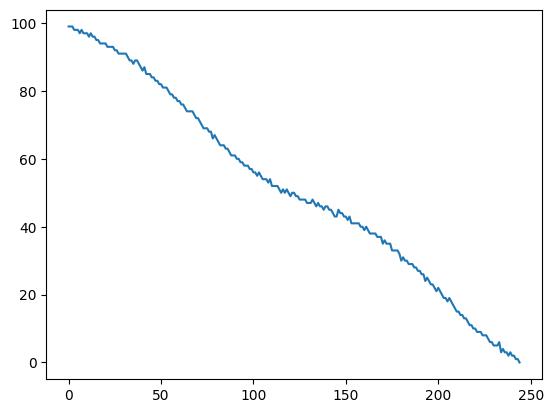

In [10]:
plt.plot(test.cpu())

/tmp/ipykernel_254816/3408880447.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.bar(x=list(range(103)), height=F.softmax(logits[0,-1,:]))


<BarContainer object of 103 artists>

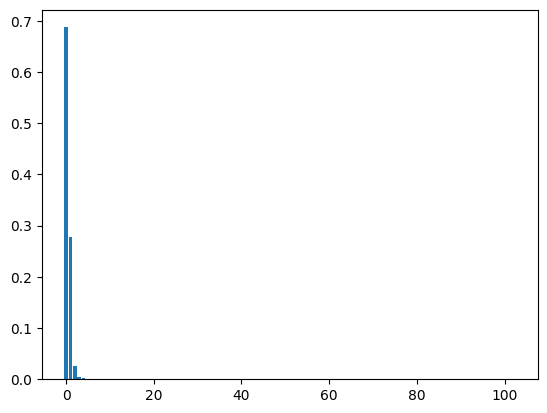

In [11]:
plt.bar(x=list(range(103)), height=F.softmax(logits[0,-1,:]))

In [12]:
logits[0,-1,:].argmax()

tensor(0)

In [18]:
def generate(model, series, min_samples = 128):
    series = series.long()
    print(series.device, series.dtype)
    predictions = []
    for t in range(min_samples, series.shape[0]):
        with torch.no_grad():
            x_item = series[:t]
            mask = get_causal_mask(len(x_item))
            predictions.append(model(x_item.unsqueeze(0), mask)[0,-1,:].argmax().item())
    return predictions

In [22]:
def generate2(model, series, tokens_to_generate=15):
    series = series.long()
    print(series.device, series.dtype)
    for _ in range(tokens_to_generate):
        with torch.no_grad():
            mask = get_causal_mask(len(series))
            next_t = model(series.unsqueeze(0), mask)[0,-1,:].argmax()
            #print(next_t)
        series = torch.concat([series, next_t.unsqueeze(0)])
    return series

cuda:0 torch.int64


[]

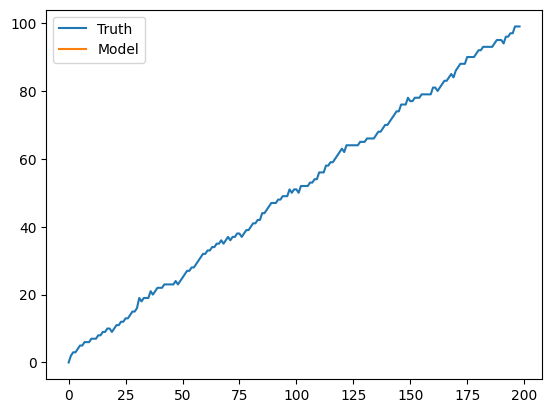

In [23]:
ground_truth = test_tensors[1]
model.to('cuda:0')
result = generate(model, ground_truth.to('cuda:0'), min_samples=512)
plt.plot(list(range(ground_truth.shape[0])), ground_truth, label='Truth')
plt.plot(list(range(512, ground_truth.shape[0])), result, label='Model')
plt.legend()
plt.plot()

cuda:0 torch.int64


[]

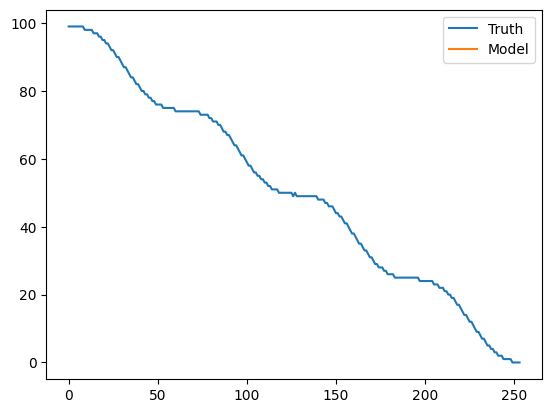

In [24]:
ground_truth = test_tensors[2]
model.to('cuda:0')
result = generate(model, ground_truth.to('cuda:0'), min_samples=512)
plt.plot(list(range(ground_truth.shape[0])), ground_truth, label='Truth')
plt.plot(list(range(512, ground_truth.shape[0])), result, label='Model')
plt.legend()
plt.plot()

cuda:0 torch.int64


/home/pratikdoshi/projects/torch_env/lib64/python3.13/site-packages/torch/nn/functional.py:6616: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /__w/TheRock/TheRock/external-builds/pytorch/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:812.)
  attn_output = scaled_dot_product_attention(


[]

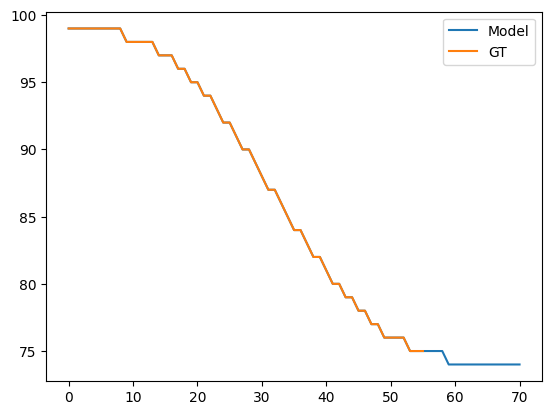

In [25]:
length = 56
ground_truth = test_tensors[2][:length]
model.to('cuda:0')

result = generate2(model, ground_truth.to('cuda:0'))
plt.plot(result.cpu(), label='Model')
plt.plot(ground_truth.cpu(), label='GT')
plt.legend()
plt.plot()

cuda:0 torch.int64


[]

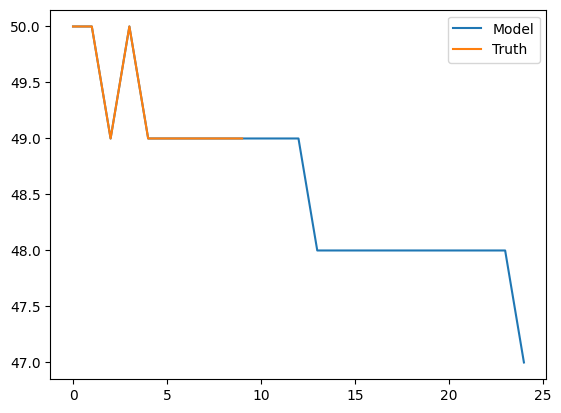

In [26]:
length = 134
ground_truth = test_tensors[2][:length]
model.to('cuda:0')
result = generate2(model, ground_truth.to('cuda:0'))
plt.plot(result[length-10:].cpu(), label='Model')
plt.plot(result[length-10:length].cpu(), label='Truth')
plt.legend()
plt.plot()

In [27]:
result[length-10:].cpu()

tensor([50, 50, 49, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48,
        48, 48, 48, 48, 48, 48, 47])

In [28]:
result[length-10:length].cpu()

tensor([50, 50, 49, 50, 49, 49, 49, 49, 49, 49])

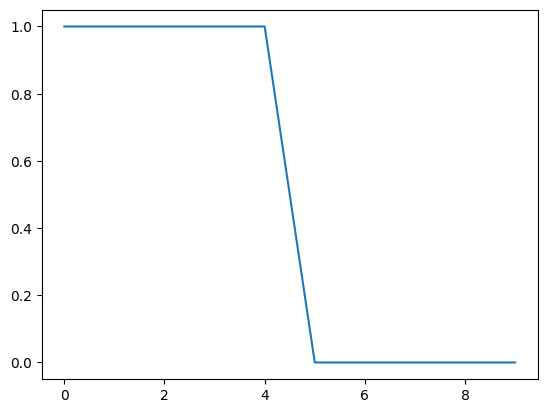

In [29]:
plt.plot(test_tensors[2][-10:])

cuda:0 torch.int64


[]

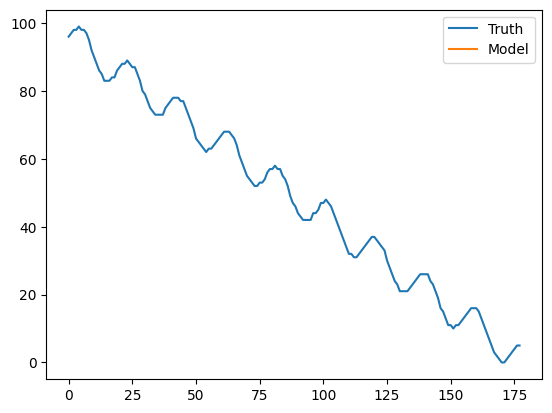

In [30]:
ground_truth = test_tensors[3]
model.to('cuda:0')
result = generate(model, ground_truth.to('cuda:0'), min_samples=512)
plt.plot(list(range(ground_truth.shape[0])), ground_truth, label='Truth')
plt.plot(list(range(512, ground_truth.shape[0])), result, label='Model')
plt.legend()
plt.plot()

cuda:0 torch.int64


[]

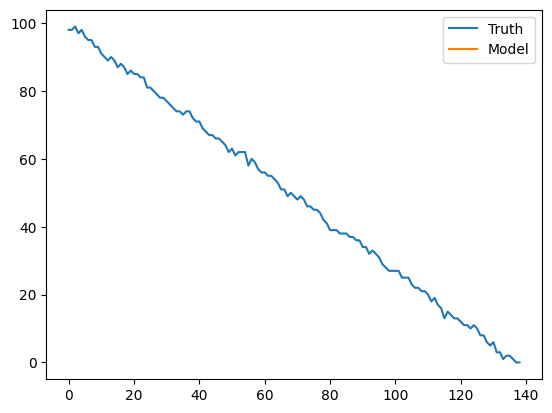

In [81]:
ground_truth = test_tensors[-1]
model.to('cuda:0')
result = generate(model, ground_truth.to('cuda:0'), min_samples=512)
plt.plot(list(range(ground_truth.shape[0])), ground_truth, label='Truth')
plt.plot(list(range(512, ground_truth.shape[0])), result, label='Model')
plt.legend()
plt.plot()

cuda:0 torch.int64


[]

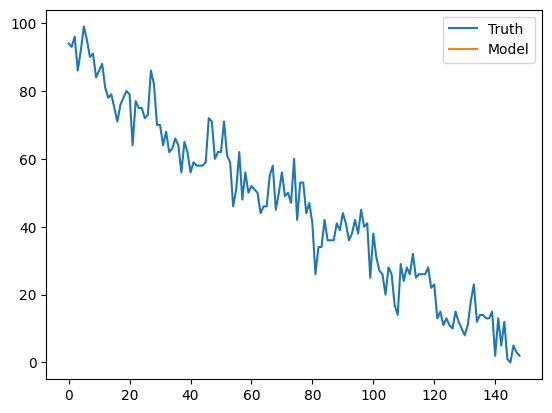

In [32]:
ground_truth = test_tensors[512]
model.to('cuda:0')
result = generate(model, ground_truth.to('cuda:0'), min_samples=512)
plt.plot(list(range(ground_truth.shape[0])), ground_truth, label='Truth')
plt.plot(list(range(512, ground_truth.shape[0])), result, label='Model')
plt.legend()
plt.plot()